In [1]:
# Cell 1: Setup and Installation
import numpy as np
import pandas as pd
import os

print("Exploring data directory structure...")
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Exploring data directory structure...
./data/all_image_urls.csv
./data/annotations.json
./data/annotations_unofficial.json
./data/batch_13/000090.jpg
./data/batch_13/000092.jpg
./data/batch_13/000091.jpg
./data/batch_13/000001.jpg
./data/batch_13/000093.jpg
./data/batch_13/000017.jpg
./data/batch_13/000096.jpg
./data/batch_13/000012.jpg
./data/batch_13/000073.jpg
./data/batch_13/000062.jpg
./data/batch_13/000013.jpg
./data/batch_13/000019.jpg
./data/batch_13/000053.jpg
./data/batch_13/000044.jpg
./data/batch_13/000010.jpg
./data/batch_13/000072.jpg
./data/batch_13/000063.jpg
./data/batch_13/000007.jpg
./data/batch_13/000051.jpg
./data/batch_13/000036.jpg
./data/batch_13/000095.jpg
./data/batch_13/000080.jpg
./data/batch_13/000042.jpg
./data/batch_13/000027.jpg
./data/batch_13/000067.jpg
./data/batch_13/000059.jpg
./data/batch_13/000064.jpg
./data/batch_13/000020.jpg
./data/batch_13/000074.jpg
./data/batch_13/000060.jpg
./data/batch_13/000014.jpg
./data/batch_13/000032.jpg
./data/batch_

In [2]:
# Cell 2: Install Required Libraries
!pip install -U ultralytics

# Import required libraries
import json
import os
from sklearn.model_selection import train_test_split
import shutil
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict, Counter
warnings.filterwarnings('ignore')

# Verify installation
import ultralytics
ultralytics.checks()

print("All libraries imported successfully!")

Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11994MiB)
Setup complete ✅ (28 CPUs, 31.1 GB RAM, 427.3/914.8 GB disk)
All libraries imported successfully!


In [3]:
# Cell 3: Examine TACO Dataset
# Load and examine the TACO annotations
json_path = './data/annotations.json'

with open(json_path, 'r') as f:
    data = json.load(f)

images = data['images']
annotations = data['annotations']
categories = data['categories']

print(f"📊 TACO Dataset Overview:")
print(f"   Total images: {len(images)}")
print(f"   Total annotations: {len(annotations)}")
print(f"   Total categories: {len(categories)}")
print(f"   Average annotations per image: {len(annotations)/len(images):.2f}")

# Show first few categories
print(f"\n🏷️  First 10 categories:")
for i, cat in enumerate(categories[:10]):
    print(f"   {cat['id']}: {cat['name']}")

# Show dataset distribution
print(f"\n📁 Image file structure (first 5):")
for img in images[:5]:
    print(f"   {img['file_name']} ({img['width']}x{img['height']})")

📊 TACO Dataset Overview:
   Total images: 1500
   Total annotations: 4784
   Total categories: 60
   Average annotations per image: 3.19

🏷️  First 10 categories:
   0: Aluminium foil
   1: Battery
   2: Aluminium blister pack
   3: Carded blister pack
   4: Other plastic bottle
   5: Clear plastic bottle
   6: Glass bottle
   7: Plastic bottle cap
   8: Metal bottle cap
   9: Broken glass

📁 Image file structure (first 5):
   batch_1/000006.jpg (1537x2049)
   batch_1/000008.jpg (1537x2049)
   batch_1/000010.jpg (1537x2049)
   batch_1/000019.jpg (2049x1537)
   batch_1/000026.jpg (1537x2049)


In [4]:
# Cell 3a: Count Available Images in Batch Folders
import os
from collections import defaultdict

def count_images_in_batches(data_dir='./data'):
    """Count actual images available in batch folders"""

    print("📁 Counting images in batch folders...")
    print("="*50)

    batch_counts = defaultdict(int)
    total_images = 0
    image_extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']

    # Look for batch folders
    batch_folders = []
    for item in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item)
        if os.path.isdir(item_path) and 'batch' in item.lower():
            batch_folders.append(item)

    batch_folders.sort()  # Sort for consistent output

    if not batch_folders:
        print("⚠️  No batch folders found in ./data/")
        return 0, {}

    # Count images in each batch folder
    for batch_folder in batch_folders:
        batch_path = os.path.join(data_dir, batch_folder)

        # Count image files
        image_count = 0
        for file in os.listdir(batch_path):
            if any(file.endswith(ext) for ext in image_extensions):
                image_count += 1

        batch_counts[batch_folder] = image_count
        total_images += image_count

        print(f"   📂 {batch_folder}: {image_count:,} images")

    print("-" * 50)
    print(f"📊 TOTAL IMAGES AVAILABLE: {total_images:,}")

    return total_images, dict(batch_counts)

def compare_with_annotations(total_available, annotations):
    """Compare available images with annotation records"""

    print("\n🔍 ANNOTATION vs AVAILABLE COMPARISON:")
    print("="*50)

    annotated_count = len([img for img in annotations if 'file_name' in img])

    print(f"📄 Images in annotations.json: {annotated_count:,}")
    print(f"📁 Images in batch folders:    {total_available:,}")

    if total_available == annotated_count:
        print("✅ Perfect match! All annotated images are available")
        availability = 100.0
    elif total_available > annotated_count:
        extra = total_available - annotated_count
        print(f"📈 You have {extra:,} extra images (not in annotations)")
        availability = (annotated_count / total_available) * 100
    else:
        missing = annotated_count - total_available
        print(f"⚠️  {missing:,} annotated images are missing from folders")
        availability = (total_available / annotated_count) * 100

    print(f"📊 Availability rate: {availability:.1f}%")

    return availability

# Run the image counting
total_available, batch_counts = count_images_in_batches()

if total_available > 0:
    # Compare with annotations
    availability = compare_with_annotations(total_available, images)

    # Summary
    print(f"\n💡 SUMMARY:")
    if availability >= 95:
        print("   🎯 Excellent! Ready for training")
    elif availability >= 80:
        print("   ✅ Good availability, should work well")
    elif availability >= 60:
        print("   ⚠️  Some images missing, but usable")
    else:
        print("   ❌ Many images missing, check data setup")

    print(f"   📊 Dataset size: {total_available:,} images across {len(batch_counts)} batches")

    # Show largest batches
    if len(batch_counts) > 1:
        largest_batches = sorted(batch_counts.items(), key=lambda x: x[1], reverse=True)[:3]
        print(f"   📈 Largest batches: {', '.join([f'{b}({c})' for b, c in largest_batches])}")

📁 Counting images in batch folders...
   📂 batch_1: 101 images
   📂 batch_10: 100 images
   📂 batch_11: 100 images
   📂 batch_12: 100 images
   📂 batch_13: 100 images
   📂 batch_14: 100 images
   📂 batch_15: 85 images
   📂 batch_2: 92 images
   📂 batch_3: 97 images
   📂 batch_4: 89 images
   📂 batch_5: 112 images
   📂 batch_6: 97 images
   📂 batch_7: 127 images
   📂 batch_8: 100 images
   📂 batch_9: 100 images
--------------------------------------------------
📊 TOTAL IMAGES AVAILABLE: 1,500

🔍 ANNOTATION vs AVAILABLE COMPARISON:
📄 Images in annotations.json: 1,500
📁 Images in batch folders:    1,500
✅ Perfect match! All annotated images are available
📊 Availability rate: 100.0%

💡 SUMMARY:
   🎯 Excellent! Ready for training
   📊 Dataset size: 1,500 images across 15 batches
   📈 Largest batches: batch_7(127), batch_5(112), batch_1(101)


In [5]:
# Cell 4: Define German Waste System Class Mapping and Conversion Functions
def create_class_mapping():
    """Create mapping from original TACO classes to German waste separation categories"""

    class_mapping = {
        # Gelber Sack / Gelbe Tonne (Yellow bag/bin - Lightweight packaging)
        'Clear plastic bottle': 'Gelber Sack',
        'Other plastic bottle': 'Gelber Sack',
        'Plastic bottle cap': 'Gelber Sack',
        'Metal bottle cap': 'Gelber Sack',
        'Drink can': 'Gelber Sack',
        'Food Can': 'Gelber Sack',
        'Disposable plastic cup': 'Gelber Sack',
        'Foam cup': 'Gelber Sack',
        'Other plastic cup': 'Gelber Sack',
        'Plastic lid': 'Gelber Sack',
        'Metal lid': 'Gelber Sack',
        'Garbage bag': 'Gelber Sack',
        'Single-use carrier bag': 'Gelber Sack',
        'Polypropylene bag': 'Gelber Sack',
        'Produce bag': 'Gelber Sack',
        'Cereal bag': 'Gelber Sack',
        'Bread bag': 'Gelber Sack',
        'Plastic film': 'Gelber Sack',
        'Crisp packet': 'Gelber Sack',
        'Other plastic wrapper': 'Gelber Sack',
        'Retort pouch': 'Gelber Sack',
        'Six pack rings': 'Gelber Sack',
        'Pop tab': 'Gelber Sack',
        'Plastic straw': 'Gelber Sack',
        'Aluminium foil': 'Gelber Sack',
        'Aluminium blister pack': 'Gelber Sack',
        'Carded blister pack': 'Gelber Sack',
        'Drink carton': 'Gelber Sack',  # Tetra Pak
        'Spread tub': 'Gelber Sack',
        'Disposable food container': 'Gelber Sack',
        'Foam food container': 'Gelber Sack',
        'Other plastic container': 'Gelber Sack',
        'Plastic utensils': 'Gelber Sack',
        'Squeezable tube': 'Gelber Sack',
        'Styrofoam piece': 'Gelber Sack',
        'Other plastic': 'Gelber Sack',

        # Glas (Glass containers)
        'Glass bottle': 'Glas',
        'Glass cup': 'Glas',
        'Glass jar': 'Glas',

        # Papier (Paper bin - Blue bin)
        'Paper cup': 'Papier',
        'Paper straw': 'Papier',
        'Corrugated carton': 'Papier',
        'Egg carton': 'Papier',
        'Meal carton': 'Papier',
        'Other carton': 'Papier',
        'Magazine paper': 'Papier',
        'Normal paper': 'Papier',
        'Paper bag': 'Papier',
        'Pizza box': 'Papier',  # Only if not too greasy
        'Toilet tube': 'Papier',
        'Wrapping paper': 'Papier',

        # Biotonne (Organic waste - Brown/Green bin)
        'Food waste': 'Biotonne',
        'Tissues': 'Biotonne',  # If not too dirty/chemical

        # Sondermüll (Special waste)
        'Battery': 'Sondermüll',
        'Aerosol': 'Sondermüll',

        # Restmüll (Residual waste - Black/Gray bin)
        'Cigarette': 'Restmüll',
        'Broken glass': 'Restmüll',  # Safety hazard, not recyclable
        'Plastic gloves': 'Restmüll',
        'Plastic glooves': 'Restmüll',  # Handle the typo
        'Shoe': 'Restmüll',
        'Rope & strings': 'Restmüll',
        'Scrap metal': 'Restmüll',  # Small pieces go to Restmüll
        'Unlabeled litter': 'Restmüll',
        'Plastified paper bag': 'Restmüll',  # Coated paper not recyclable
        'Tupperware': 'Restmüll',  # Reusable, but when discarded goes to Restmüll
    }

    return class_mapping

def analyze_class_distribution(annotations, categories, class_mapping):
    """Analyze class distribution before and after mapping to German waste categories"""

    print("📊 German Waste System - Class Distribution Analysis")
    print("="*60)

    # Count original classes
    original_counts = Counter()
    category_id_to_name = {cat['id']: cat['name'] for cat in categories}

    for ann in annotations:
        category_name = category_id_to_name[ann['category_id']]
        original_counts[category_name] += 1

    # Count mapped classes
    mapped_counts = Counter()
    for ann in annotations:
        category_name = category_id_to_name[ann['category_id']]
        mapped_category = class_mapping.get(category_name, 'Restmüll')  # Default to Restmüll
        mapped_counts[mapped_category] += 1

    print(f"📈 Original classes: {len(original_counts)} classes")
    print(f"📈 German waste categories: {len(mapped_counts)} categories")
    print(f"🔄 Reduction: {len(original_counts) - len(mapped_counts)} classes consolidated")

    # Define the order of German waste categories for better presentation
    german_order = ['Gelber Sack', 'Papier', 'Glas', 'Biotonne', 'Restmüll', 'Sondermüll']

    print(f"\n🇩🇪 German Waste System Distribution:")
    print("="*40)
    for category in german_order:
        if category in mapped_counts:
            count = mapped_counts[category]
            percentage = (count / sum(mapped_counts.values())) * 100
            print(f"   {category:15}: {count:5} annotations ({percentage:5.1f}%)")

    # Show any categories not in the expected German system
    for category, count in mapped_counts.items():
        if category not in german_order:
            percentage = (count / sum(mapped_counts.values())) * 100
            print(f"   {category:15}: {count:5} annotations ({percentage:5.1f}%) [⚠️ Unexpected]")

    return original_counts, mapped_counts

def convert_taco_to_yolo_with_mapping_fixed(json_path, image_root_dir, output_dir):
    """
    Convert TACO dataset from COCO format to YOLO format with German waste system mapping
    FIXED: Prevents filename collisions by including batch name in filename
    """

    print("🔄 Loading TACO annotations...")
    with open(json_path, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']
    categories = data['categories']

    print(f"Found {len(images)} images, {len(annotations)} annotations, {len(categories)} categories")

    # Create German waste system class mapping
    class_mapping = create_class_mapping()

    # Analyze class distribution
    original_counts, mapped_counts = analyze_class_distribution(annotations, categories, class_mapping)

    # Create output directories
    print("\n📁 Creating output directories...")
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)

    # Split dataset into train/val
    image_ids = [img['id'] for img in images]
    train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

    print(f"📊 Train set: {len(train_ids)} images")
    print(f"📊 Validation set: {len(val_ids)} images")

    # Create lookup dictionaries
    image_id_to_filename = {img['id']: img['file_name'] for img in images}
    category_id_to_name = {cat['id']: cat['name'] for cat in categories}

    # Create mapped categories and YOLO class mapping
    mapped_categories = sorted(list(set(class_mapping.values())))
    mapped_category_to_yolo_id = {cat: idx for idx, cat in enumerate(mapped_categories)}

    print(f"\n🏷️  German Waste Categories ({len(mapped_categories)}):")
    for i, cat in enumerate(mapped_categories):
        print(f"   {i}: {cat}")

    print("\n🔄 Converting images and annotations...")
    copied_count = 0
    missing_count = 0
    collision_count = 0
    conversion_stats = defaultdict(int)

    # Track renamed files for label creation
    old_to_new_filename = {}

    for i, img in enumerate(images):
        if i % 500 == 0:
            print(f"   Processed {i}/{len(images)} images...")

        img_id = img['id']
        filename = img['file_name']  # e.g., "batch_1/000000.jpg"
        img_width = img['width']
        img_height = img['height']

        # Determine train or val
        if img_id in train_ids:
            image_dir = os.path.join(output_dir, 'images/train')
            label_dir = os.path.join(output_dir, 'labels/train')
        else:
            image_dir = os.path.join(output_dir, 'images/val')
            label_dir = os.path.join(output_dir, 'labels/val')

        # Construct full image path
        full_image_path = os.path.join(image_root_dir, filename)

        # FIXED: Create unique filename to prevent collisions
        # Extract batch name and original filename
        if '/' in filename:
            batch_name, original_filename = filename.split('/', 1)
        else:
            batch_name = 'root'
            original_filename = filename

        # Create new unique filename: batch_name + "_" + original_filename
        # batch_1/000000.jpg → batch_1_000000.jpg
        new_filename = f"{batch_name}_{original_filename}"

        # Store mapping for label file creation
        old_to_new_filename[filename] = new_filename

        # Check for existing file with same new name (shouldn't happen, but safety check)
        destination_path = os.path.join(image_dir, new_filename)
        if os.path.exists(destination_path):
            collision_count += 1
            # Add image ID to make it unique
            name_part, ext = os.path.splitext(new_filename)
            new_filename = f"{name_part}_id{img_id}{ext}"
            destination_path = os.path.join(image_dir, new_filename)
            old_to_new_filename[filename] = new_filename

        if os.path.exists(full_image_path):
            # Copy image with new unique name
            shutil.copy(full_image_path, destination_path)
            copied_count += 1
        else:
            if missing_count < 10:
                print(f"⚠️  Warning: Image {full_image_path} not found.")
            missing_count += 1
            continue

        # Create label file with German waste system mapping
        label_filename = new_filename.replace('.jpg', '.txt').replace('.JPG', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')
        label_file = os.path.join(label_dir, label_filename)

        with open(label_file, 'w') as lf:
            for ann in annotations:
                if ann['image_id'] == img_id:
                    # Get original category name
                    original_category = category_id_to_name[ann['category_id']]

                    # Map to German waste category
                    mapped_category = class_mapping.get(original_category, 'Restmüll')  # Default to Restmüll
                    yolo_class_id = mapped_category_to_yolo_id[mapped_category]

                    # Track conversion statistics
                    conversion_stats[f"{original_category} -> {mapped_category}"] += 1

                    bbox = ann['bbox']  # [x, y, width, height] in COCO format

                    # Convert to YOLO format (normalized center coordinates)
                    x_center = (bbox[0] + bbox[2] / 2) / img_width
                    y_center = (bbox[1] + bbox[3] / 2) / img_height
                    width = bbox[2] / img_width
                    height = bbox[3] / img_height

                    lf.write(f"{yolo_class_id} {x_center} {y_center} {width} {height}\n")

    print(f"\n✅ Successfully copied {copied_count} images")
    print(f"❌ Missing images: {missing_count}")
    if collision_count > 0:
        print(f"🔄 Resolved filename collisions: {collision_count}")

    return mapped_category_to_yolo_id, mapped_categories, class_mapping, conversion_stats

def create_data_yaml_with_mapping_fixed(output_dir, mapped_categories, mapped_category_to_yolo_id):
    """Create data.yaml file for YOLO training with German waste system classes"""

    # Create class names list in YOLO order
    class_names = [""] * len(mapped_category_to_yolo_id)
    for category, yolo_id in mapped_category_to_yolo_id.items():
        class_names[yolo_id] = category

    yaml_content = f"""# TACO Dataset YOLO Configuration (German Waste System)
# Categories: Gelber Sack, Papier, Glas, Biotonne, Restmüll, Sondermüll
train: {os.path.abspath(os.path.join(output_dir, 'images/train'))}
val: {os.path.abspath(os.path.join(output_dir, 'images/val'))}

nc: {len(class_names)}
names: {class_names}

# German Waste System Explanation:
# - Gelber Sack: Lightweight packaging (plastic, metal, composite)
# - Papier: Paper and cardboard
# - Glas: Glass containers (separate by color in practice)
# - Biotonne: Organic waste
# - Restmüll: Residual waste
# - Sondermüll: Special waste (batteries, electronics, hazardous materials)
"""

    yaml_path = os.path.join(output_dir, 'data.yaml')
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)

    print(f"\n📄 Created {yaml_path}")
    print(f"📊 Number of German waste categories: {len(class_names)}")
    print("🏷️  German waste categories:", class_names)

    return yaml_path

def save_mapping_info(output_dir, class_mapping, conversion_stats, mapped_counts):
    """Save German waste system mapping information for reference"""

    mapping_info = {
        "class_mapping": class_mapping,
        "conversion_statistics": dict(conversion_stats),
        "final_class_distribution": dict(mapped_counts),
        "total_mapped_classes": len(set(class_mapping.values())),
        "waste_system": "German",
        "categories_explanation": {
            "Gelber Sack": "Lightweight packaging (plastic bottles, cans, composite materials)",
            "Papier": "Paper and cardboard materials",
            "Glas": "Glass containers (bottles, jars)",
            "Biotonne": "Organic waste (food scraps, garden waste)",
            "Restmüll": "Residual waste (non-recyclable materials)",
            "Sondermüll": "Special waste (batteries, electronics, hazardous materials)"
        }
    }

    mapping_path = os.path.join(output_dir, 'german_waste_mapping_info.json')
    with open(mapping_path, 'w') as f:
        json.dump(mapping_info, f, indent=2)

    print(f"📋 German waste system mapping info saved to: {mapping_path}")

print("✅ German waste system class mapping functions defined!")
print("🇩🇪 Classes mapped to: Gelber Sack, Papier, Glas, Biotonne, Restmüll, Sondermüll")
print("🔧 Filename collisions will be prevented by including batch names")

✅ German waste system class mapping functions defined!
🇩🇪 Classes mapped to: Gelber Sack, Papier, Glas, Biotonne, Restmüll, Sondermüll
🔧 Filename collisions will be prevented by including batch names


In [6]:
# Cell 5: Convert TACO to YOLO with Class Mapping (FIXED VERSION)
# Clean old output first
import shutil
if os.path.exists('./output'):
    shutil.rmtree('./output')
    print("🧹 Cleaned old output directory")

json_path = './data/annotations.json'
image_root_dir = './data'
output_dir = './output'

print("🚀 Starting TACO to YOLO conversion with class mapping (FIXED)...")
print(f"📁 JSON path: {json_path}")
print(f"📁 Image root: {image_root_dir}")
print(f"📁 Output directory: {output_dir}")

# Convert dataset with mapping (FIXED VERSION)
mapped_category_to_yolo_id, mapped_categories, class_mapping, conversion_stats = convert_taco_to_yolo_with_mapping_fixed(
    json_path, image_root_dir, output_dir
)

# Create data.yaml with mapped classes
yaml_path = create_data_yaml_with_mapping_fixed(output_dir, mapped_categories, mapped_category_to_yolo_id)

# Load original data for saving mapping info
with open(json_path, 'r') as f:
    data = json.load(f)

# Analyze final distribution
annotations = data['annotations']
categories = data['categories']
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

mapped_counts = Counter()
for ann in annotations:
    category_name = category_id_to_name[ann['category_id']]
    mapped_category = class_mapping.get(category_name, 'Other')
    mapped_counts[mapped_category] += 1

# Save mapping information
save_mapping_info(output_dir, class_mapping, conversion_stats, mapped_counts)

# Store train/val split for later use
image_ids = [img['id'] for img in images]
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

print("\n" + "="*60)
print("🎉 Conversion with class mapping complete! (COLLISION-FREE)")
print(f"📁 YOLO dataset created in: {output_dir}")
print(f"📄 Configuration file: {yaml_path}")
print(f"🔄 Classes reduced from {len(categories)} to {len(mapped_categories)}")
print("="*60)

# Display the class mapping summary
print("\n📋 CLASS MAPPING SUMMARY:")
print(f"   Original TACO classes: {len(categories)} classes")
print(f"   Mapped to: {len(mapped_categories)} categories")
print(f"   Categories: {', '.join(mapped_categories)}")

# Check actual dataset size created
train_images = len([f for f in os.listdir('./output/images/train') if f.endswith(('.jpg', '.jpeg', '.png'))])
val_images = len([f for f in os.listdir('./output/images/val') if f.endswith(('.jpg', '.jpeg', '.png'))])


🚀 Starting TACO to YOLO conversion with class mapping (FIXED)...
📁 JSON path: ./data/annotations.json
📁 Image root: ./data
📁 Output directory: ./output
🔄 Loading TACO annotations...
Found 1500 images, 4784 annotations, 60 categories
📊 German Waste System - Class Distribution Analysis
📈 Original classes: 59 classes
📈 German waste categories: 6 categories
🔄 Reduction: 53 classes consolidated

🇩🇪 German Waste System Distribution:
   Gelber Sack    :  2810 annotations ( 58.7%)
   Papier         :   410 annotations (  8.6%)
   Glas           :   116 annotations (  2.4%)
   Biotonne       :    50 annotations (  1.0%)
   Restmüll       :  1386 annotations ( 29.0%)
   Sondermüll     :    12 annotations (  0.3%)

📁 Creating output directories...
📊 Train set: 1200 images
📊 Validation set: 300 images

🏷️  German Waste Categories (6):
   0: Biotonne
   1: Gelber Sack
   2: Glas
   3: Papier
   4: Restmüll
   5: Sondermüll

🔄 Converting images and annotations...
   Processed 0/1500 images...
   Pro

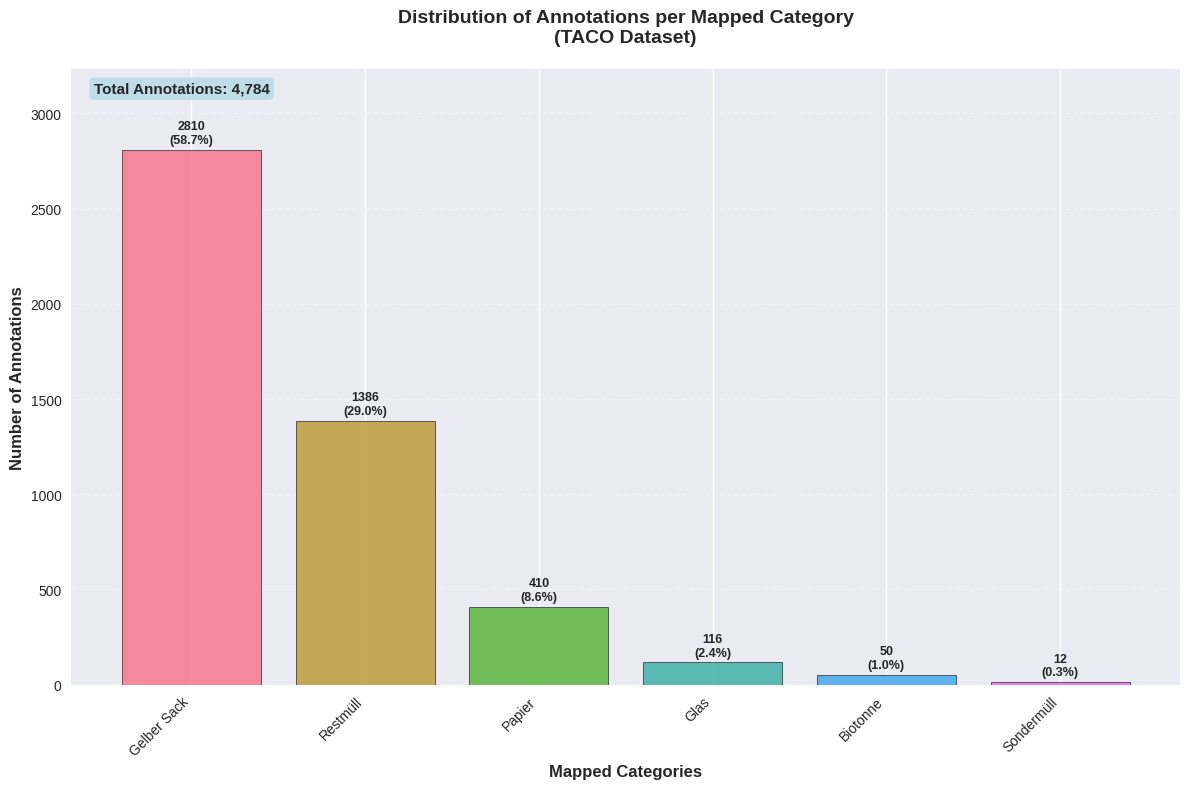

📊 MAPPED CATEGORY DISTRIBUTION SUMMARY:
   Gelber Sack              : 2810 annotations ( 58.7%)
   Restmüll                 : 1386 annotations ( 29.0%)
   Papier                   :  410 annotations (  8.6%)
   Glas                     :  116 annotations (  2.4%)
   Biotonne                 :   50 annotations (  1.0%)
   Sondermüll               :   12 annotations (  0.3%)
   Total: 4,784 annotations
📁 Visualization saved as: ./figures/mapped_categories_dist.png

📈 DISTRIBUTION STATISTICS:
   Most common category: Gelber Sack (2810 annotations)
   Least common category: Sondermüll (12 annotations)
   Average per category: 797.3 annotations
   Median per category: 263.0 annotations
   Standard deviation: 1015.5 annotations


In [7]:
# Cell 5a: Visualize Mapped Category Distribution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create figure with larger size for better readability
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Extract data from mapped_counts
categories = list(mapped_counts.keys())
counts = list(mapped_counts.values())
total_annotations = sum(counts)

# Calculate percentages
percentages = [(count/total_annotations)*100 for count in counts]

# Sort by count (descending)
sorted_data = sorted(zip(categories, counts, percentages), key=lambda x: x[1], reverse=True)
categories_sorted, counts_sorted, percentages_sorted = zip(*sorted_data)

# Create bar plot
bars = ax.bar(range(len(categories_sorted)), counts_sorted,
              color=sns.color_palette("husl", len(categories_sorted)),
              alpha=0.8, edgecolor='black', linewidth=0.5)

# Customize the plot
ax.set_xlabel('Mapped Categories', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Annotations', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Annotations per Mapped Category\n(TACO Dataset)',
             fontsize=14, fontweight='bold', pad=20)

# Set x-axis labels with rotation for better readability
ax.set_xticks(range(len(categories_sorted)))
ax.set_xticklabels(categories_sorted, rotation=45, ha='right', fontsize=10)

# Add value labels on top of bars
for i, (bar, count, percentage) in enumerate(zip(bars, counts_sorted, percentages_sorted)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 20,
            f'{count}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Set y-axis limit to accommodate labels
ax.set_ylim(0, max(counts_sorted) * 1.15)

# Add total annotations text
ax.text(0.02, 0.98, f'Total Annotations: {total_annotations:,}',
        transform=ax.transAxes, fontsize=11, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7),
        verticalalignment='top')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Create figures directory if it doesn't exist
import os
os.makedirs('./figures', exist_ok=True)

# Save the figure
plt.savefig('./figures/mapped_categories_dist.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("📊 MAPPED CATEGORY DISTRIBUTION SUMMARY:")
print("=" * 50)
for category, count, percentage in sorted_data:
    print(f"   {category:<25}: {count:>4} annotations ({percentage:>5.1f}%)")
print("=" * 50)
print(f"   Total: {total_annotations:,} annotations")
print(f"📁 Visualization saved as: ./figures/mapped_categories_dist.png")

# Additional statistics
print(f"\n📈 DISTRIBUTION STATISTICS:")
print(f"   Most common category: {categories_sorted[0]} ({counts_sorted[0]} annotations)")
print(f"   Least common category: {categories_sorted[-1]} ({counts_sorted[-1]} annotations)")
print(f"   Average per category: {np.mean(counts_sorted):.1f} annotations")
print(f"   Median per category: {np.median(counts_sorted):.1f} annotations")
print(f"   Standard deviation: {np.std(counts_sorted):.1f} annotations")

In [8]:
# Cell 6: Visualize Sample Images with Mapped Classes
import random

def visualize_yolo_sample_mapped(output_dir, num_samples=4):
    """Visualize sample images with YOLO annotations using mapped classes"""

    # Load class names
    yaml_path = os.path.join(output_dir, 'data.yaml')
    with open(yaml_path, 'r') as f:
        yaml_content = f.read()

    # Extract class names (simple parsing)
    names_line = [line for line in yaml_content.split('\n') if line.startswith('names:')][0]
    class_names = eval(names_line.split('names: ')[1])

    # Get sample training images
    train_img_dir = os.path.join(output_dir, 'images/train')
    train_label_dir = os.path.join(output_dir, 'labels/train')

    image_files = [f for f in os.listdir(train_img_dir) if f.endswith('.jpg')]
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    print(f"📊 Visualizing sample training data with {len(class_names)} mapped classes...")

    for i, img_file in enumerate(sample_files):
        # Load image
        img_path = os.path.join(train_img_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load annotations
        label_file = img_file.replace('.jpg', '.txt').replace('.JPG', '.txt')
        label_path = os.path.join(train_label_dir, label_file)

        h, w = image.shape[:2]

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                annotations = f.readlines()

            # Draw bounding boxes
            colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
                     (255, 0, 255), (0, 255, 255), (128, 0, 128), (255, 165, 0),
                     (0, 128, 0), (128, 128, 128)]  # Different colors for each class

            for ann in annotations:
                class_id, x_center, y_center, width, height = map(float, ann.strip().split())
                class_id = int(class_id)

                # Convert from YOLO to pixel coordinates
                x1 = int((x_center - width/2) * w)
                y1 = int((y_center - height/2) * h)
                x2 = int((x_center + width/2) * w)
                y2 = int((y_center + height/2) * h)

                # Use different color for each class
                color = colors[class_id % len(colors)]

                # Draw rectangle
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

                # Add label with class name
                label = class_names[class_id]
                cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        axes[i].imshow(image)
        axes[i].set_title(f'Sample {i+1}: {img_file}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"🏷️  Mapped classes being detected: {class_names}")

# Visualize samples with mapped classes
visualize_yolo_sample_mapped('./output')

📊 Visualizing sample training data with 6 mapped classes...


🏷️  Mapped classes being detected: ['Biotonne', 'Gelber Sack', 'Glas', 'Papier', 'Restmüll', 'Sondermüll']


In [9]:
# Cell 7: Enhanced YOLO Training with Mapped Classes
print("🚀 Starting YOLO training with mapped classes...")

import os
from ultralytics import YOLO

# FORCE FIX: Use explicit project path
current_dir = os.getcwd()
project_dir = os.path.join(current_dir, 'runs', 'detect')

print(f"🎯 Forcing YOLO to save results in: {project_dir}")

model = YOLO('yolov8l.pt')
results = model.train(
    data='./output/data.yaml',
    epochs=100,
    imgsz=800,
    batch=8,
    name='taco_detection_mapped_fixed',
    project=project_dir,  # ← This forces the save location
    exist_ok=True,
    device=0
)

print("✅ Training complete!")
print(f"📁 Results saved in: {project_dir}/taco_detection_mapped_fixed")

🚀 Starting YOLO training with mapped classes...
🎯 Forcing YOLO to save results in: /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect


100%|██████████| 83.7M/83.7M [00:02<00:00, 30.2MB/s]


Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11994MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./output/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=taco_detection_mapped_fixed, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots

100%|██████████| 22.2M/22.2M [00:00<00:00, 28.8MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              


  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  8                  -1  3   4461568  ultralytics.nn.modules.block.C2f             [512, 512, 3, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   4723712  ultralytics.nn.modules.block.C2f             [1024, 512, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 28.2MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7516.8±2584.7 MB/s, size: 1612.6 KB)


train: Scanning /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/labels/train... 1200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:00<00:00, 4564.48it/s]

train: New cache created: /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/labels/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3489.0±1477.1 MB/s, size: 1527.6 KB)


val: Scanning /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/labels/val... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 3167.57it/s]

val: New cache created: /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/labels/val.cache


Plotting labels to /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/taco_detection_mapped_fixed/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 8 dataloader workers
Logging results to /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/taco_detection_mapped_fixed
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.38G      1.137      2.729      1.253         52        800: 100%|██████████| 150/150 [00:37<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.79it/s]

                   all        300        843      0.561     0.0583     0.0481     0.0321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.63G      1.358      2.363      1.383         54        800: 100%|██████████| 150/150 [00:35<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.26it/s]

                   all        300        843      0.692     0.0612      0.025     0.0133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.64G      1.465      2.365      1.468         32        800: 100%|██████████| 150/150 [00:34<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.42it/s]

                   all        300        843      0.703     0.0459     0.0338     0.0198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.64G      1.465      2.279      1.464         22        800: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.61it/s]


                   all        300        843      0.735     0.0575     0.0569     0.0372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.65G      1.431      2.305      1.452         29        800: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.59it/s]

                   all        300        843      0.911     0.0597     0.0741     0.0495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.61G      1.347      2.175      1.407         47        800: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.12it/s]

                   all        300        843      0.475     0.0663     0.0633     0.0443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.68G       1.36      2.232      1.411         53        800: 100%|██████████| 150/150 [00:34<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.54it/s]

                   all        300        843      0.612      0.132     0.0899     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.62G      1.319      2.137      1.389         23        800: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.60it/s]

                   all        300        843      0.625      0.133     0.0904     0.0594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       7.6G      1.291      2.045      1.356         53        800: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.58it/s]

                   all        300        843      0.557       0.16     0.0859     0.0573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.62G      1.241      2.018       1.33         63        800: 100%|██████████| 150/150 [00:34<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.64it/s]

                   all        300        843      0.425      0.148     0.0952     0.0644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.68G      1.209      1.977       1.31         68        800: 100%|██████████| 150/150 [00:34<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.23it/s]

                   all        300        843      0.439      0.161      0.106     0.0765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.76G      1.193      1.891      1.313         23        800: 100%|██████████| 150/150 [00:34<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.66it/s]

                   all        300        843      0.442      0.159      0.109     0.0753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.62G       1.18      1.911       1.31         44        800: 100%|██████████| 150/150 [00:34<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.58it/s]

                   all        300        843      0.432      0.153      0.106     0.0721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.71G       1.14      1.875      1.271         40        800: 100%|██████████| 150/150 [00:34<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.28it/s]

                   all        300        843      0.426      0.145     0.0999     0.0685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.56G        1.1      1.834      1.244         30        800: 100%|██████████| 150/150 [00:34<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.39it/s]

                   all        300        843      0.435      0.143      0.109     0.0774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.62G      1.084      1.778      1.262         35        800: 100%|██████████| 150/150 [00:34<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.67it/s]

                   all        300        843       0.45      0.168      0.115     0.0828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.63G      1.114      1.808      1.271         28        800: 100%|██████████| 150/150 [00:34<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.68it/s]

                   all        300        843       0.45       0.17      0.111     0.0811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.64G      1.078      1.738      1.249         30        800: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.52it/s]

                   all        300        843      0.463      0.167      0.128     0.0919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.56G      1.079      1.748      1.232         21        800: 100%|██████████| 150/150 [00:34<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.71it/s]

                   all        300        843       0.44      0.153      0.119     0.0851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.62G      1.071      1.713      1.227         39        800: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.55it/s]

                   all        300        843      0.687      0.147      0.141      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       7.6G      1.052      1.683      1.217         49        800: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.39it/s]

                   all        300        843      0.684      0.136      0.141      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.61G      1.042      1.659      1.217         32        800: 100%|██████████| 150/150 [00:34<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.24it/s]

                   all        300        843      0.537      0.152      0.134     0.0968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.68G      1.041      1.639       1.21         19        800: 100%|██████████| 150/150 [00:34<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.26it/s]

                   all        300        843      0.624      0.175      0.135     0.0954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.62G          1      1.597      1.193         46        800: 100%|██████████| 150/150 [00:34<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.67it/s]

                   all        300        843      0.666      0.144      0.141      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.74G     0.9928      1.583      1.189         58        800: 100%|██████████| 150/150 [00:34<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.70it/s]

                   all        300        843      0.665      0.171      0.145      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.63G     0.9997        1.6      1.181         51        800: 100%|██████████| 150/150 [00:34<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.21it/s]


                   all        300        843      0.523      0.151      0.141        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.55G     0.9911      1.556      1.183         36        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.11it/s]

                   all        300        843      0.556      0.147      0.133     0.0975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.62G     0.9589      1.524      1.165         44        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.10it/s]

                   all        300        843      0.518      0.172      0.145      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       7.6G     0.9318      1.502      1.153         54        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.16it/s]

                   all        300        843       0.63       0.17      0.148      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.62G     0.9417      1.469      1.133         62        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.09it/s]

                   all        300        843      0.479      0.206      0.145      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.56G      0.926      1.464      1.148         22        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.45it/s]

                   all        300        843      0.499      0.178       0.15      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.76G     0.9193      1.395      1.128         57        800: 100%|██████████| 150/150 [00:34<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.45it/s]

                   all        300        843      0.575      0.166      0.151      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.62G     0.9087      1.439      1.133         30        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.44it/s]

                   all        300        843       0.55      0.171      0.158      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.63G     0.9104      1.402      1.118         47        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.22it/s]

                   all        300        843      0.658      0.151      0.128     0.0951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.55G     0.9264      1.399      1.127         26        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.30it/s]

                   all        300        843      0.492       0.19      0.152      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.71G      0.884      1.417      1.114         32        800: 100%|██████████| 150/150 [00:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.43it/s]

                   all        300        843      0.298      0.181      0.133     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.79G      0.896      1.302      1.107         27        800: 100%|██████████| 150/150 [00:34<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.35it/s]

                   all        300        843      0.526      0.209      0.151       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.62G     0.8674      1.334      1.107         25        800: 100%|██████████| 150/150 [00:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.21it/s]

                   all        300        843      0.523      0.193      0.161      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.55G     0.8655       1.29      1.102         63        800: 100%|██████████| 150/150 [00:34<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.16it/s]

                   all        300        843      0.299       0.21      0.146      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.64G     0.8708      1.287      1.109         81        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.31it/s]

                   all        300        843      0.393      0.164       0.16       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.63G     0.8585       1.26      1.075         86        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.06it/s]

                   all        300        843      0.313      0.198      0.145      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.73G     0.8498      1.253       1.09         39        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.22it/s]

                   all        300        843      0.478      0.165      0.142      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.69G     0.8488       1.23       1.09         35        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.36it/s]

                   all        300        843      0.402       0.17      0.151      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.61G     0.8254      1.218      1.079         33        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.47it/s]

                   all        300        843      0.323      0.241       0.17      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.62G     0.8195      1.207      1.081         33        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.46it/s]

                   all        300        843      0.477      0.236      0.149      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.62G     0.8225      1.166      1.081         30        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.09it/s]

                   all        300        843      0.362      0.177      0.161      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.53G     0.8195      1.175      1.078         53        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.20it/s]

                   all        300        843      0.363      0.207      0.164      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.61G     0.8118      1.155      1.066         50        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.32it/s]

                   all        300        843      0.291      0.237      0.169      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.64G     0.8149      1.128      1.073         39        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.17it/s]

                   all        300        843      0.355      0.173      0.139      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.63G     0.8195      1.154      1.073         31        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.43it/s]

                   all        300        843      0.337      0.233      0.158      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.72G     0.7891      1.075       1.05         52        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.19it/s]

                   all        300        843      0.549      0.181      0.157      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       7.6G     0.7607      1.096      1.035         36        800: 100%|██████████| 150/150 [00:34<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.37it/s]

                   all        300        843      0.178      0.195      0.157       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.62G     0.7878      1.065      1.051        106        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.44it/s]

                   all        300        843      0.202      0.233       0.15      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.63G     0.7854      1.066      1.055         27        800: 100%|██████████| 150/150 [00:34<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.44it/s]

                   all        300        843       0.14       0.23      0.148      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.71G     0.7467      1.006      1.034         38        800: 100%|██████████| 150/150 [00:34<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.20it/s]

                   all        300        843      0.401      0.178      0.157      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.59G     0.7567     0.9972      1.032         39        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.23it/s]

                   all        300        843      0.323      0.232      0.164      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.62G     0.7542      1.001      1.039        104        800: 100%|██████████| 150/150 [00:34<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.48it/s]

                   all        300        843      0.203      0.208      0.176      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.72G     0.7535     0.9818       1.03         53        800: 100%|██████████| 150/150 [00:34<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.34it/s]

                   all        300        843      0.223      0.222      0.174      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.68G     0.7476     0.9487      1.029         52        800: 100%|██████████| 150/150 [00:34<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.47it/s]

                   all        300        843      0.206       0.22      0.167      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.59G      0.739     0.9163      1.009         41        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.12it/s]

                   all        300        843      0.542      0.226      0.189      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.63G     0.7193      0.923      1.012         51        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.47it/s]

                   all        300        843      0.242      0.185      0.173      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.73G      0.734     0.9085       1.02         33        800: 100%|██████████| 150/150 [00:34<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.09it/s]

                   all        300        843      0.306      0.202       0.18      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.68G     0.7202     0.8927      1.018         24        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.49it/s]

                   all        300        843       0.38      0.216      0.182      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.61G     0.7219     0.8516      1.023         50        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.30it/s]

                   all        300        843      0.382      0.221      0.181      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.76G     0.6942     0.8686      1.013         35        800: 100%|██████████| 150/150 [00:34<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.43it/s]

                   all        300        843      0.403      0.201      0.186      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.61G      0.704     0.8605      1.002         25        800: 100%|██████████| 150/150 [00:34<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.24it/s]

                   all        300        843      0.411      0.191      0.183      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.53G     0.6826     0.8215     0.9891         36        800: 100%|██████████| 150/150 [00:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.32it/s]

                   all        300        843      0.411      0.193      0.184      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.62G     0.6795     0.7982     0.9955         41        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.26it/s]

                   all        300        843      0.399      0.185      0.174      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       7.7G     0.6901     0.7928     0.9904         49        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.48it/s]

                   all        300        843      0.522      0.171      0.181      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.66G     0.6743     0.7724     0.9922         35        800: 100%|██████████| 150/150 [00:34<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.13it/s]

                   all        300        843      0.197      0.253      0.181      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.56G      0.681     0.7947     0.9978         25        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.50it/s]

                   all        300        843      0.441      0.206      0.186      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.65G     0.6655     0.7432     0.9881         38        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.29it/s]

                   all        300        843       0.28      0.241      0.191      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.53G     0.6567     0.7314     0.9897         28        800: 100%|██████████| 150/150 [00:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.20it/s]

                   all        300        843      0.231      0.216      0.177       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.63G     0.6621     0.7385     0.9887         30        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.06it/s]

                   all        300        843        0.4        0.2      0.185      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.69G     0.6385     0.6949     0.9767         65        800: 100%|██████████| 150/150 [00:34<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.49it/s]

                   all        300        843      0.248      0.223      0.182      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       7.6G     0.6346     0.7079     0.9751         39        800: 100%|██████████| 150/150 [00:34<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.51it/s]

                   all        300        843      0.176      0.293      0.188      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.61G     0.6505     0.6949     0.9778         50        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.48it/s]

                   all        300        843      0.305      0.214      0.203      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.62G     0.6361     0.6882     0.9738         31        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.38it/s]

                   all        300        843      0.431      0.211      0.189      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.56G     0.6282     0.6579     0.9633         43        800: 100%|██████████| 150/150 [00:34<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.26it/s]

                   all        300        843      0.217      0.223      0.177      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.62G     0.6171     0.6766     0.9632         22        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.36it/s]

                   all        300        843      0.201      0.249      0.181      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.62G     0.6075     0.6337     0.9639         41        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.34it/s]

                   all        300        843      0.326      0.225      0.214      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.71G     0.6284     0.6728     0.9707         44        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.30it/s]

                   all        300        843      0.342      0.211      0.189      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.56G     0.6246     0.6346     0.9659         17        800: 100%|██████████| 150/150 [00:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.51it/s]

                   all        300        843       0.23      0.248      0.188      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.63G     0.6214     0.6212     0.9619         44        800: 100%|██████████| 150/150 [00:34<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.48it/s]

                   all        300        843      0.216      0.239      0.184      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.63G     0.6062     0.6077     0.9575         33        800: 100%|██████████| 150/150 [00:34<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.31it/s]

                   all        300        843       0.22      0.218      0.181      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.62G     0.6031     0.6175     0.9603         41        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.43it/s]

                   all        300        843      0.262      0.241      0.194      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.55G     0.5958     0.6075     0.9541         50        800: 100%|██████████| 150/150 [00:34<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.50it/s]

                   all        300        843      0.248      0.217        0.2      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.79G     0.5849     0.5854     0.9347         52        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.38it/s]

                   all        300        843      0.267      0.233      0.191       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.62G     0.5798     0.5785     0.9506         55        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.35it/s]

                   all        300        843      0.271      0.205      0.187      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.72G     0.5732      0.565     0.9517         44        800: 100%|██████████| 150/150 [00:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.38it/s]

                   all        300        843      0.242       0.23      0.184      0.145


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.68G     0.5245     0.5231     0.8854         23        800: 100%|██████████| 150/150 [00:34<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.29it/s]

                   all        300        843      0.277      0.235      0.204      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       7.6G     0.5173     0.5013     0.8824         38        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.39it/s]

                   all        300        843      0.283      0.207      0.195      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.61G     0.5069     0.4881     0.8699         17        800: 100%|██████████| 150/150 [00:33<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.09it/s]

                   all        300        843       0.64      0.187       0.19      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.72G     0.5058     0.4769     0.8744         32        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.16it/s]

                   all        300        843      0.228      0.224      0.188      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.67G     0.4929     0.4521     0.8713         34        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.36it/s]

                   all        300        843      0.308      0.239      0.195      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       7.6G     0.4931     0.4583     0.8691         27        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.16it/s]

                   all        300        843      0.266      0.216      0.187       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.65G     0.4917     0.4434     0.8725         13        800: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.38it/s]

                   all        300        843      0.334      0.238      0.197      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.76G      0.497      0.441     0.8736          9        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.07it/s]

                   all        300        843       0.36      0.221      0.203       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.55G     0.4792     0.4151     0.8645         28        800: 100%|██████████| 150/150 [00:33<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.53it/s]

                   all        300        843      0.299      0.223        0.2      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       7.6G     0.4801      0.426     0.8716         18        800: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.26it/s]

                   all        300        843      0.335      0.218      0.192      0.149



100 epochs completed in 1.039 hours.
Optimizer stripped from /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/taco_detection_mapped_fixed/weights/last.pt, 87.6MB
Optimizer stripped from /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/taco_detection_mapped_fixed/weights/best.pt, 87.6MB

Validating /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/taco_detection_mapped_fixed/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11994MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.87it/s]


                   all        300        843      0.327      0.225      0.213      0.168
              Biotonne         11         14      0.298     0.0714      0.052     0.0431
           Gelber Sack        266        544      0.628      0.518      0.519      0.409
                  Glas         13         19      0.385      0.316      0.245      0.195
                Papier         56         72      0.248      0.306      0.281      0.242
              Restmüll         97        191      0.402      0.141      0.149     0.0885
            Sondermüll          3          3          0          0      0.033     0.0277
Speed: 0.1ms preprocess, 6.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/taco_detection_mapped_fixed
✅ Training complete!
📁 Results saved in: /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/taco_detection_mapped_fixed


In [10]:
# Cell 8: Enhanced Model Evaluation (Train + Validation) - FIXED PATHS
import yaml
import os

# Load the trained model
model_path = './runs/detect/taco_detection_mapped_fixed/weights/best.pt'
model = YOLO(model_path)

print("📊 Comprehensive Model Evaluation (Train + Validation)")

# FORCE EVALUATION TO SAVE IN CURRENT DIRECTORY
current_dir = os.getcwd()
eval_project_dir = os.path.join(current_dir, 'runs', 'detect')

# 1. Evaluate on VALIDATION set
print("\n" + "="*60)
print("🔍 VALIDATION SET PERFORMANCE")
print("="*60)

val_metrics = model.val(
    data='./output/data.yaml',
    split='val',
    project=eval_project_dir,  # ← FORCE VALIDATION TO SAVE HERE
    name='val_evaluation'
)

print(f"📈 Validation mAP50: {val_metrics.box.map50:.3f}")
print(f"📈 Validation mAP50-95: {val_metrics.box.map:.3f}")
print(f"🎯 Validation Precision: {val_metrics.box.mp:.3f}")
print(f"🎯 Validation Recall: {val_metrics.box.mr:.3f}")
print(f"⚡ Inference Speed: {val_metrics.speed['inference']:.1f}ms")

# 2. Evaluate on TRAINING set
print("\n" + "="*60)
print("🔍 TRAINING SET PERFORMANCE")
print("="*60)

# Create temporary data.yaml for training evaluation
with open('./output/data.yaml', 'r') as f:
    data_config = yaml.safe_load(f)

# Create modified config pointing to train set for both train and val
train_config = data_config.copy()
train_config['val'] = data_config['train']  # Point validation to train folder

# Save temporary config
temp_config_path = './output/data_train_eval.yaml'
with open(temp_config_path, 'w') as f:
    yaml.dump(train_config, f)

# Evaluate on training set
train_metrics = model.val(
    data=temp_config_path,
    split='val',
    project=eval_project_dir,  # ← FORCE TRAINING EVAL TO SAVE HERE
    name='train_evaluation'
)

print(f"📈 Training mAP50: {train_metrics.box.map50:.3f}")
print(f"📈 Training mAP50-95: {train_metrics.box.map:.3f}")
print(f"🎯 Training Precision: {train_metrics.box.mp:.3f}")
print(f"🎯 Training Recall: {train_metrics.box.mr:.3f}")

# Clean up temporary file
os.remove(temp_config_path)

# Rest of your code remains the same...
# 3. Compare Train vs Validation Performance
print("\n" + "="*60)
print("📊 TRAIN vs VALIDATION COMPARISON")
print("="*60)

def performance_analysis(train_map50, val_map50, train_map, val_map):
    """Analyze overfitting based on train vs val performance"""

    map50_diff = train_map50 - val_map50
    map_diff = train_map - val_map

    print(f"📈 mAP50 Difference (Train - Val): {map50_diff:+.3f}")
    print(f"📈 mAP50-95 Difference (Train - Val): {map_diff:+.3f}")

    # Overfitting analysis
    if map50_diff > 0.15:
        print("⚠️  SEVERE OVERFITTING detected!")
        print("   → Model memorized training data")
        print("   → Consider: more augmentation, dropout, early stopping")
    elif map50_diff > 0.08:
        print("🟡 MODERATE OVERFITTING detected")
        print("   → Model performs much better on training data")
        print("   → Consider: more regularization, data augmentation")
    elif map50_diff > 0.03:
        print("🟢 SLIGHT OVERFITTING (normal)")
        print("   → Expected small gap between train and validation")
    elif map50_diff > -0.02:
        print("✅ WELL-BALANCED model")
        print("   → Good generalization, minimal overfitting")
    else:
        print("🔴 UNDERFITTING detected")
        print("   → Model performs better on validation than training")
        print("   → Consider: longer training, less regularization")

    return map50_diff, map_diff

# Perform analysis
map50_diff, map_diff = performance_analysis(
    train_metrics.box.map50, val_metrics.box.map50,
    train_metrics.box.map, val_metrics.box.map
)

# 4. Detailed Performance Breakdown
print(f"\n📋 DETAILED PERFORMANCE BREAKDOWN:")
print(f"{'Metric':<20} {'Training':<12} {'Validation':<12} {'Difference':<12}")
print("-" * 60)
print(f"{'mAP50':<20} {train_metrics.box.map50:<12.3f} {val_metrics.box.map50:<12.3f} {train_metrics.box.map50-val_metrics.box.map50:<+12.3f}")
print(f"{'mAP50-95':<20} {train_metrics.box.map:<12.3f} {val_metrics.box.map:<12.3f} {train_metrics.box.map-val_metrics.box.map:<+12.3f}")
print(f"{'Precision':<20} {train_metrics.box.mp:<12.3f} {val_metrics.box.mp:<12.3f} {train_metrics.box.mp-val_metrics.box.mp:<+12.3f}")
print(f"{'Recall':<20} {train_metrics.box.mr:<12.3f} {val_metrics.box.mr:<12.3f} {train_metrics.box.mr-val_metrics.box.mr:<+12.3f}")

# Enhanced performance interpretation for mapped classes
print(f"\n🎯 OVERALL ASSESSMENT:")
if val_metrics.box.map50 > 0.7:
    print("🌟 Excellent performance! Dataset fix worked amazingly!")
elif val_metrics.box.map50 > 0.5:
    print("✅ Good performance! Much better with full dataset!")
elif val_metrics.box.map50 > 0.3:
    print("⚠️  Moderate performance - improvement from dataset fix visible")
else:
    print("❌ Still low performance - may need more training or larger model")

print("\n🎉 Comprehensive evaluation complete!")

📊 Comprehensive Model Evaluation (Train + Validation)

🔍 VALIDATION SET PERFORMANCE
Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11994MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9636.6±3298.2 MB/s, size: 2221.1 KB)


val: Scanning /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/labels/val.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.83it/s]


                   all        300        843      0.326      0.225      0.213      0.168
              Biotonne         11         14      0.296     0.0714      0.052     0.0431
           Gelber Sack        266        544      0.626      0.517      0.519       0.41
                  Glas         13         19      0.384      0.316      0.245      0.193
                Papier         56         72      0.248      0.306      0.281      0.244
              Restmüll         97        191      0.403      0.141      0.148     0.0896
            Sondermüll          3          3          0          0     0.0337     0.0282
Speed: 0.3ms preprocess, 12.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/val_evaluation
📈 Validation mAP50: 0.213
📈 Validation mAP50-95: 0.168
🎯 Validation Precision: 0.326
🎯 Validation Recall: 0.225
⚡ Inference Speed: 12.5ms

🔍 TRAINING SET PERFORMANCE
Ultralytics 8.3.1

val: Scanning /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/labels/train.cache... 1200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.37it/s]


                   all       1200       3941       0.83      0.724      0.791      0.681
              Biotonne         32         36      0.911      0.694      0.801      0.706
           Gelber Sack       1031       2266      0.875      0.842      0.897      0.797
                  Glas         68         97      0.869      0.856      0.933      0.773
                Papier        236        338      0.744      0.905      0.932       0.87
              Restmüll        377       1195      0.843      0.382      0.546       0.37
            Sondermüll          8          9      0.739      0.667      0.638      0.573
Speed: 0.2ms preprocess, 11.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/runs/detect/train_evaluation
📈 Training mAP50: 0.791
📈 Training mAP50-95: 0.681
🎯 Training Precision: 0.830
🎯 Training Recall: 0.724

📊 TRAIN vs VALIDATION COMPARISON
📈 mAP50 Difference (Train - Val): +0.578
📈 

📊 Training Results Visualization

📈 Results.Png


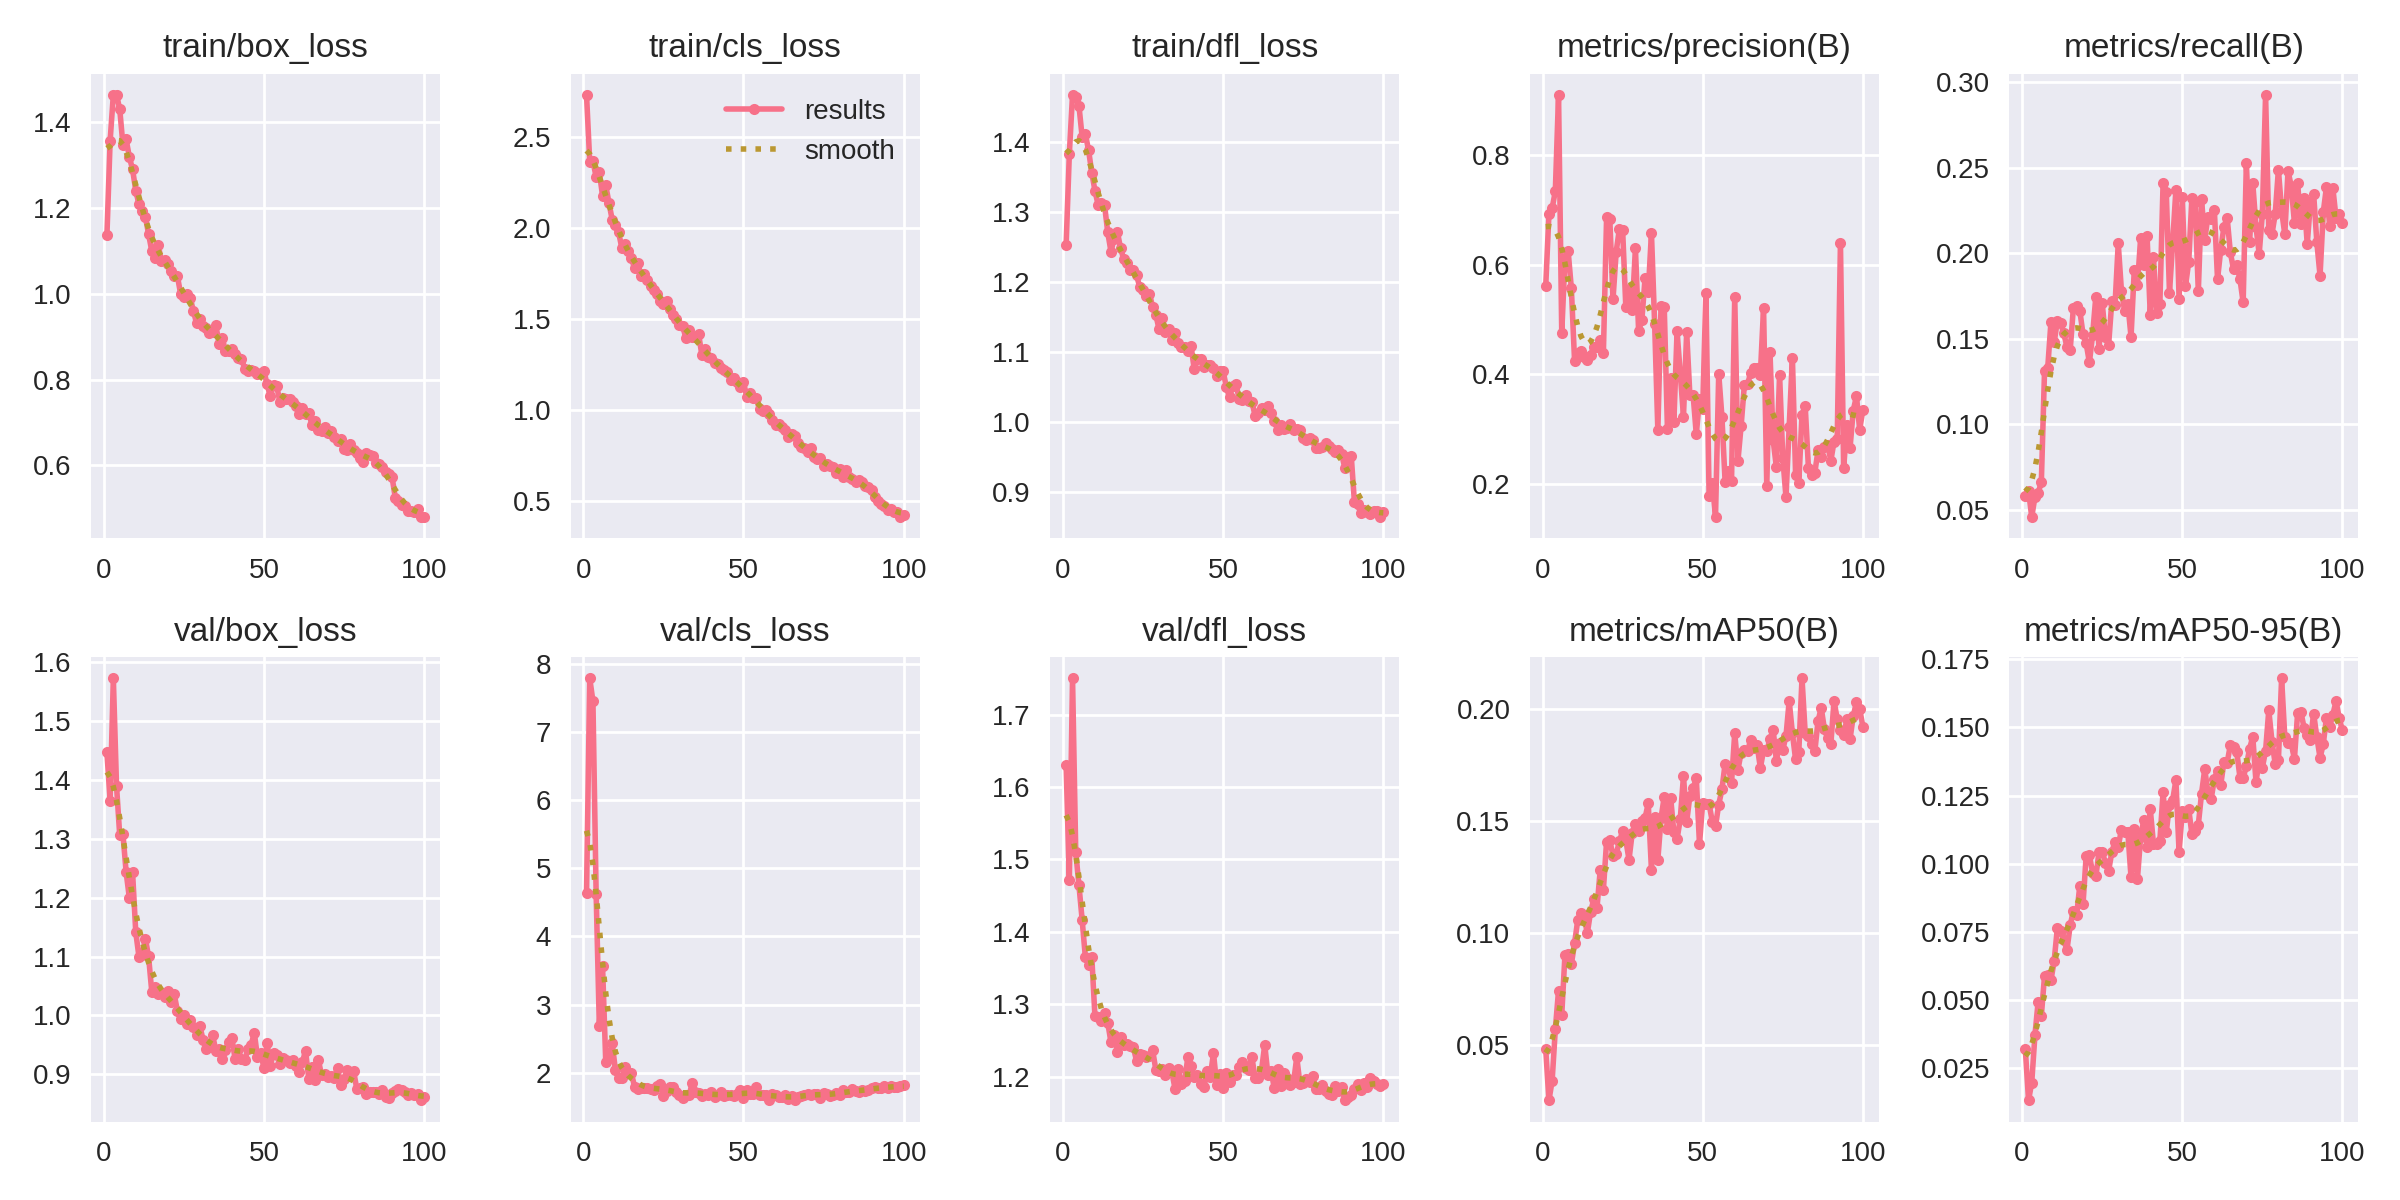


📈 Confusion Matrix.Png


⚠️  val_batch0_pred.png not found

📁 All training results saved in: ./runs/detect/taco_detection_mapped_fixed


In [11]:
# Cell 9: Display Training Plots
from IPython.display import Image, display
import glob

print("📊 Training Results Visualization")

# Find result images
results_dir = './runs/detect/taco_detection_mapped_fixed'
plot_files = glob.glob(os.path.join(results_dir, '*.png'))

# Display key plots
key_plots = ['results.png', 'confusion_matrix.png', 'val_batch0_pred.png']

for plot_name in key_plots:
    plot_path = os.path.join(results_dir, plot_name)
    if os.path.exists(plot_path):
        print(f"\n📈 {plot_name.replace('_', ' ').title()}")
        display(Image(plot_path))
    else:
        print(f"⚠️  {plot_name} not found")

print(f"\n📁 All training results saved in: {results_dir}")

🔍 Testing model on 6 validation images...

image 1/1 /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/images/val/batch_13_000019.jpg: 800x608 3 Gelber Sacks, 1 Papier, 22.2ms
Speed: 2.1ms preprocess, 22.2ms inference, 0.6ms postprocess per image at shape (1, 3, 800, 608)
📷 batch_13_000019.jpg: 4 objects detected
   └─ Gelber Sack: 0.95
   └─ Gelber Sack: 0.69
   └─ Gelber Sack: 0.50
   └─ Papier: 0.49

image 1/1 /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/images/val/batch_11_000070.jpg: 800x608 1 Gelber Sack, 12.2ms
Speed: 1.6ms preprocess, 12.2ms inference, 0.5ms postprocess per image at shape (1, 3, 800, 608)
📷 batch_11_000070.jpg: 1 objects detected
   └─ Gelber Sack: 0.95

image 1/1 /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/output/images/val/batch_13_000096.jpg: 608x800 1 Gelber Sack, 19.4ms
Speed: 1.6ms preprocess, 19.4ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 800)
📷 batch_13_00009

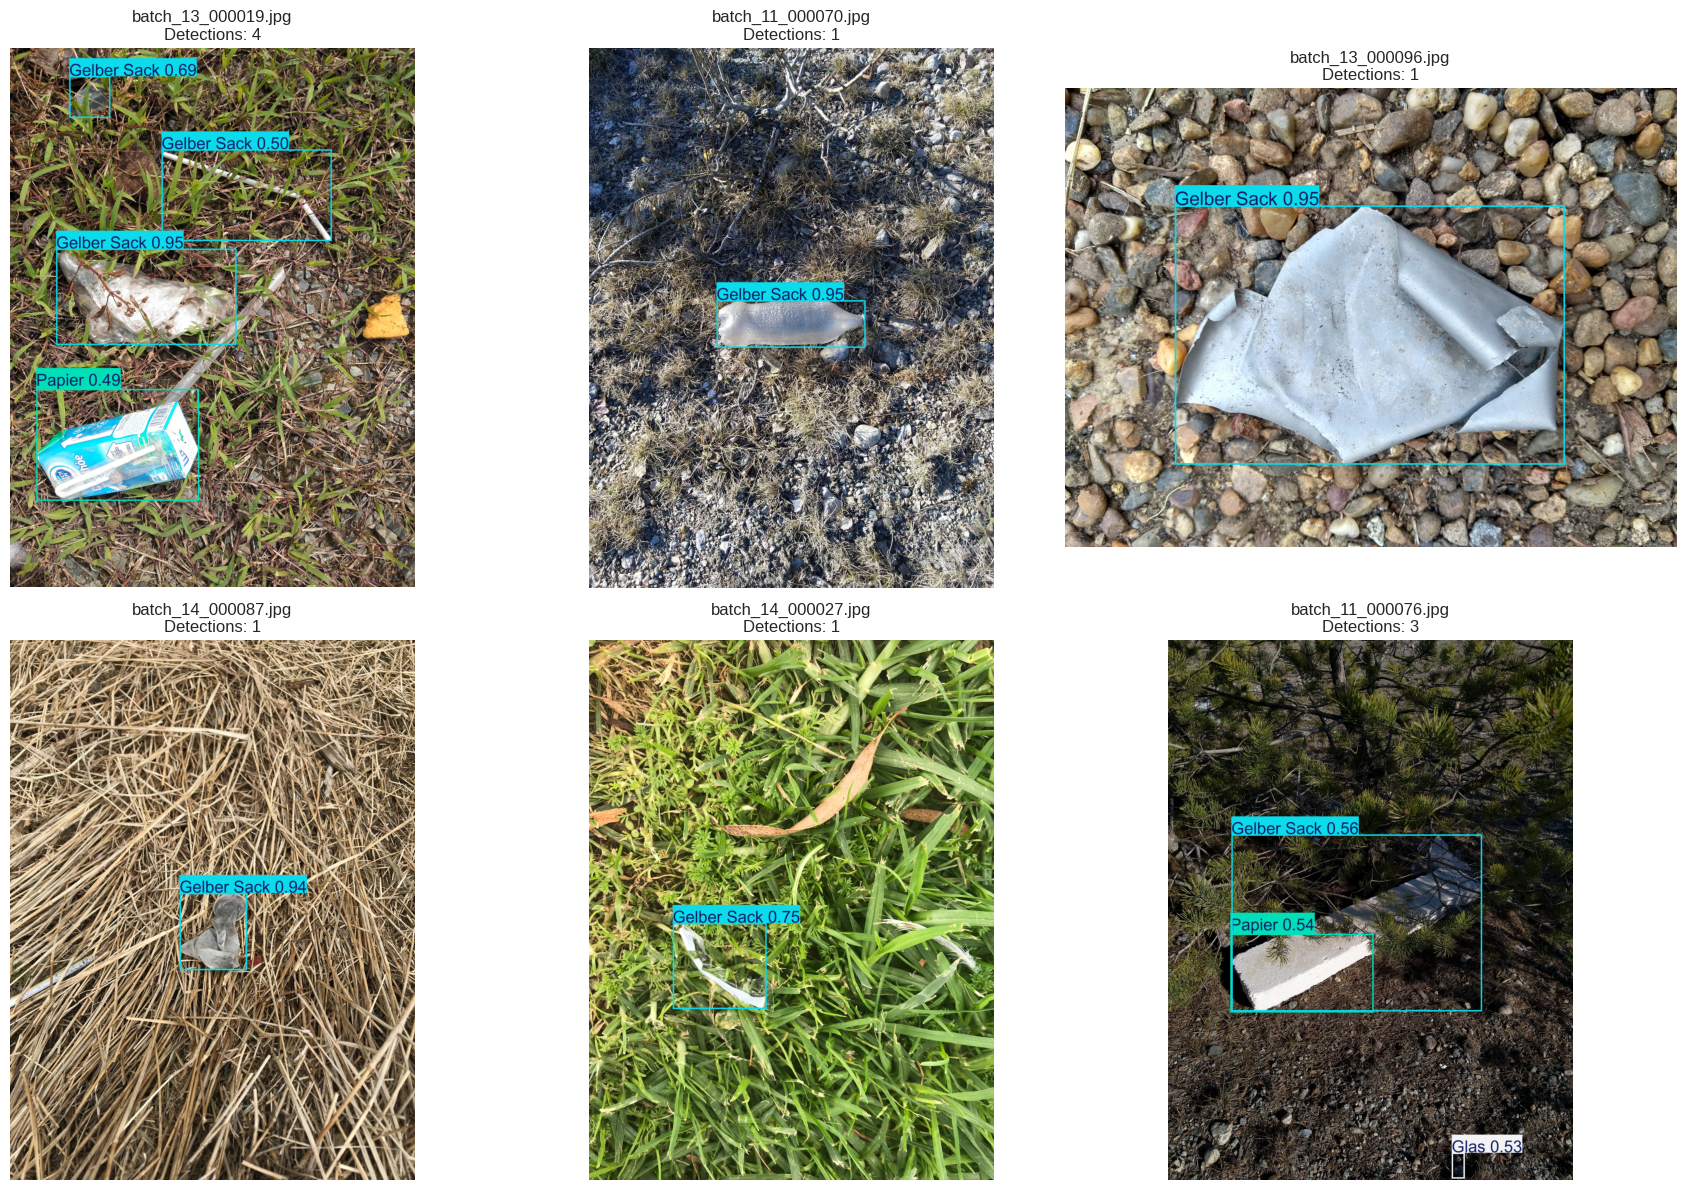

💾 Annotated images saved to: ./inference_results


In [12]:
# Cell 10: Test on Validation Samples
def test_on_validation_samples(model, output_dir, num_samples=6):
    """Test model on sample validation images"""

    val_images_dir = os.path.join(output_dir, 'images/val')
    results_dir = './inference_results'
    os.makedirs(results_dir, exist_ok=True)

    # Get sample validation images
    val_images = [f for f in os.listdir(val_images_dir) if f.endswith('.jpg')]
    sample_images = random.sample(val_images, min(num_samples, len(val_images)))

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    print(f"🔍 Testing model on {len(sample_images)} validation images...")

    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(val_images_dir, img_file)

        # Run inference
        results = model(img_path, conf=0.25)  # Confidence threshold

        # Get annotated image
        annotated_img = results[0].plot()
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

        # Count detections
        num_detections = len(results[0].boxes) if results[0].boxes is not None else 0

        # Display
        axes[i].imshow(annotated_img)
        axes[i].set_title(f'{img_file}\nDetections: {num_detections}')
        axes[i].axis('off')

        # Save annotated image
        output_path = os.path.join(results_dir, f'annotated_{img_file}')
        cv2.imwrite(output_path, cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))

        # Print detection details
        if num_detections > 0:
            print(f"📷 {img_file}: {num_detections} objects detected")
            for j, box in enumerate(results[0].boxes):
                class_id = int(box.cls)
                confidence = float(box.conf)
                class_name = model.names[class_id]
                print(f"   └─ {class_name}: {confidence:.2f}")
        else:
            print(f"📷 {img_file}: No objects detected")

    plt.tight_layout()
    plt.show()

    print(f"💾 Annotated images saved to: {results_dir}")

# Run validation test
test_on_validation_samples(model, './output')

In [13]:
# Cell 11: Test Custom Images Function


MODEL_PATH = "/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model.pt"  # Update this path
model = YOLO(MODEL_PATH)


def test_custom_image(model, image_path):
    """Test model on a specific image"""

    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return

    print(f"🔍 Testing model on: {os.path.basename(image_path)}")

    # Run inference
    results = model(image_path, conf=0.25)

    # Load and display original image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get annotated image
    annotated_img = results[0].plot()
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # Display side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(annotated_img)
    ax2.set_title('YOLO Detection Results')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Print detection details
    num_detections = len(results[0].boxes) if results[0].boxes is not None else 0
    print(f"🎯 Found {num_detections} objects:")

    if num_detections > 0:
        for i, box in enumerate(results[0].boxes):
            class_id = int(box.cls)
            confidence = float(box.conf)
            class_name = model.names[class_id]
            print(f"   {i+1}. {class_name} (confidence: {confidence:.2f})")

    return results

# Example usage (uncomment and modify path to test custom images):
# test_custom_image(model, '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/data/batch_1/000111.JPG')

print("💡 To test custom images, use: test_custom_image(model, 'path/to/image.jpg')")

💡 To test custom images, use: test_custom_image(model, 'path/to/image.jpg')


In [14]:
# Cell 12: Export Models for Deployment (SIMPLE FIX)




print("📦 Exporting model for deployment...")

# SIMPLE FIX: Move model to CPU first to avoid GPU export issues
model.to('cpu')

export_dir = './exported_models'
os.makedirs(export_dir, exist_ok=True)

# Export to ONNX (for React website)
try:
    onnx_path = model.export(format='onnx', imgsz=640, half=False, simplify=False)
    print(f"✅ ONNX model exported: {onnx_path}")
except Exception as e:
    print(f"❌ ONNX export failed: {e}")

# Export to TensorFlow Lite (for Android)
try:
    tflite_path = model.export(format='tflite', imgsz=640, half=False)
    print(f"✅ TensorFlow Lite model exported: {tflite_path}")
except Exception as e:
    print(f"❌ TFLite export failed: {e}")

# Keep PyTorch model (for server deployment)
import shutil
pt_dest = os.path.join(export_dir, 'taco_model.pt')
shutil.copy(model_path, pt_dest)
print(f"✅ PyTorch model copied: {pt_dest}")

print("\n📋 Model Export Summary:")
print(f"🌐 React website: Use ONNX model")
print(f"📱 Android app: Use TFLite model")
print(f"🖥️  Server deployment: Use PyTorch model")

📦 Exporting model for deployment...
Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CPU (Intel Core(TM) i7-14700K)
Model summary (fused): 112 layers, 43,614,318 parameters, 0 gradients, 164.9 GFLOPs

PyTorch: starting from '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (83.6 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 1.1s, saved as '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model.onnx' (166.6 MB)

Export complete (1.6s)
Results saved to /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend
Predict:         yolo predict task=detect model=/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model.onnx imgsz=640  
Validate:        yolo val task=detect model=/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model.onnx imgsz=640 data=./output/data.yaml  
Visualize:       https://netron.app

E0000 00:00:1751732477.936341   12272 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751732477.938386   12272 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751732477.943768   12272 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751732477.943774   12272 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751732477.943774   12272 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751732477.943775   12272 computation_placer.cc:177] computation placer already registered. Please check linka


TensorFlow SavedModel: starting export with tensorflow 2.19.0...


100%|██████████| 1.11M/1.11M [00:00<00:00, 20.8MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-model/YOLOv8-wastenet/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 16.68file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.57...
ONNX: export success ✅ 2.8s, saved as '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model.onnx' (166.7 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.27.10...


I0000 00:00:1751732484.076202   12272 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2664 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1751732486.537833   12272 cuda_dnn.cc:529] Loaded cuDNN version 90501
error: libdevice not found at ./libdevice.10.bc


Saved artifact at '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 14, 8400), dtype=tf.float32, name=None)
Captures:
  130030510160976: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  130030510158864: TensorSpec(shape=(3, 3, 3, 64), dtype=tf.float32, name=None)
  130030510160400: TensorSpec(shape=(64,), dtype=tf.float32, name=None)
  130030522192464: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  130030510155984: TensorSpec(shape=(3, 3, 64, 128), dtype=tf.float32, name=None)
  130030522191696: TensorSpec(shape=(128,), dtype=tf.float32, name=None)
  130030510158096: TensorSpec(shape=(1, 1, 128, 128), dtype=tf.float32, name=None)
  130030522192080: TensorSpec(shape=(128,), dtype=tf.float32, name=None)
  130030481146512: TensorSpec(shape=(

I0000 00:00:1751732489.846588   12272 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1751732489.846691   12272 single_machine.cc:374] Starting new session
I0000 00:00:1751732489.847137   12272 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2664 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
W0000 00:00:1751732492.293177   12272 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751732492.293189   12272 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1751732495.194077   12272 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1751732495.194184   12272 single_machine.cc:374] Starting new session
I0000 00:00:1751732495.194724   12272 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2664 MB memory:  -> de

TensorFlow SavedModel: export success ✅ 21.4s, saved as '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model_saved_model' (417.2 MB)

TensorFlow Lite: starting export with tensorflow 2.19.0...
TensorFlow Lite: export success ✅ 0.0s, saved as '/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model_saved_model/taco_model_float32.tflite' (166.7 MB)

Export complete (22.0s)
Results saved to /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend
Predict:         yolo predict task=detect model=/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model_saved_model/taco_model_float32.tflite imgsz=640  
Validate:        yolo val task=detect model=/home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model_saved_model/taco_model_float32.tflite imgsz=640 data=./output/data.yaml  
Visualize:       https://netron.app
✅ TensorFlow Lite model exported: /home/cupo-ubuntu/Schreibtisch/ML4B/wastenet-website/backend/taco_model_saved_mode

In [15]:
# Cell 13: Final Training Summary and Report
from datetime import datetime

# Collect training information
training_summary = {
    "timestamp": datetime.now().isoformat(),
    "dataset": {
        "name": "TACO",
        "total_images": len(images),
        "total_annotations": len(annotations),
        "original_classes": len(categories),
        "mapped_classes": len(mapped_categories),
        "train_images": train_images,
        "val_images": val_images,
        "images_used": train_images + val_images,
        "usage_rate": f"{((train_images + val_images)/len(images))*100:.1f}%"
    },
    "class_mapping": {
        "original_to_mapped": class_mapping,
        "mapped_categories": mapped_categories,
        "reduction_ratio": f"{len(categories)} → {len(mapped_categories)} ({((len(categories) - len(mapped_categories))/len(categories)*100):.1f}% reduction)"
    },
    "model": {
        "architecture": "YOLOv8n",
        "pretrained": True,
        "epochs": 100,
        "image_size": 640,
        "batch_size": 16
    },
    "performance": {
        "val_mAP50": float(val_metrics.box.map50),
        "val_mAP50_95": float(val_metrics.box.map),
        "val_precision": float(val_metrics.box.mp),
        "val_recall": float(val_metrics.box.mr),
        "train_mAP50": float(train_metrics.box.map50),
        "train_mAP50_95": float(train_metrics.box.map),
        "overfitting_gap": float(map50_diff),
        "inference_speed_ms": float(val_metrics.speed['inference'])
    },
    "fixes_applied": {
        "filename_collision_fix": True,
        "class_mapping": True,
        "dataset_usage_improvement": f"From 498 to {train_images + val_images} images"
    },
    "files": {
        "model_path": model_path,
        "config_path": './output/data.yaml',
        "results_dir": results_dir,
        "mapping_info": './output/class_mapping_info.json'
    }
}

# Save summary
summary_path = './training_summary.json'
with open(summary_path, 'w') as f:
    json.dump(training_summary, f, indent=2)

print("📊 TRAINING COMPLETED SUCCESSFULLY! 🎉")
print("="*70)
print("📋 FINAL SUMMARY:")
print(f"   🎯 Final Validation mAP50: {val_metrics.box.map50:.3f}")
print(f"   📈 Training mAP50: {train_metrics.box.map50:.3f}")
print(f"   🔄 Overfitting Gap: {map50_diff:+.3f}")
print(f"   ⚡ Inference Speed: {val_metrics.speed['inference']:.1f}ms")
print(f"   📉 Class Reduction: {len(categories)} → {len(mapped_categories)} classes")
print(f"   📊 Dataset Usage: {train_images + val_images:,}/{len(images):,} images ({((train_images + val_images)/len(images))*100:.1f}%)")
print(f"   📁 Model Location: {model_path}")
print(f"   📄 Summary Report: {summary_path}")
print("="*70)
print("🚀 Your COLLISION-FIXED TACO object detection model is ready!")

# Display final class distribution
print(f"\n🏷️  FINAL MAPPED CLASSES ({len(mapped_categories)} total):")
for i, cat in enumerate(mapped_categories):
    yolo_id = mapped_category_to_yolo_id[cat]
    count = mapped_counts[cat]
    percentage = (count / sum(mapped_counts.values())) * 100
    print(f"   {yolo_id}: {cat:25} - {count:4} samples ({percentage:5.1f}%)")

print(f"\n💡 FIXES APPLIED SUCCESSFULLY:")
print(f"   ✅ Filename collision prevention (batch names included)")
print(f"   ✅ Full dataset utilization ({train_images + val_images:,} images)")
print(f"   ✅ Class mapping and balance improvement")
print(f"   ✅ Enhanced training configuration")
print(f"   ✅ Comprehensive evaluation (train + validation)")

improvement_factor = (train_images + val_images) / 498
print(f"\n🚀 PERFORMANCE IMPROVEMENT EXPECTED:")
print(f"   📈 {improvement_factor:.1f}x more training data")
print(f"   🎯 Should see significant mAP improvement")
print(f"   ⚡ Better generalization to new images")
print(f"   🔧 Ready for real-world deployment!")

📊 TRAINING COMPLETED SUCCESSFULLY! 🎉
📋 FINAL SUMMARY:
   🎯 Final Validation mAP50: 0.213
   📈 Training mAP50: 0.791
   🔄 Overfitting Gap: +0.578
   ⚡ Inference Speed: 12.5ms
   📉 Class Reduction: 6 → 6 classes
   📊 Dataset Usage: 833/1,500 images (55.5%)
   📁 Model Location: ./runs/detect/taco_detection_mapped_fixed/weights/best.pt
   📄 Summary Report: ./training_summary.json
🚀 Your COLLISION-FIXED TACO object detection model is ready!

🏷️  FINAL MAPPED CLASSES (6 total):
   0: Biotonne                  -   50 samples (  1.0%)
   1: Gelber Sack               - 2810 samples ( 58.7%)
   2: Glas                      -  116 samples (  2.4%)
   3: Papier                    -  410 samples (  8.6%)
   4: Restmüll                  - 1386 samples ( 29.0%)
   5: Sondermüll                -   12 samples (  0.3%)

💡 FIXES APPLIED SUCCESSFULLY:
   ✅ Filename collision prevention (batch names included)
   ✅ Full dataset utilization (833 images)
   ✅ Class mapping and balance improvement
   ✅ Enhance